# Prediccion del precio de las viviendas mediante arboles de regresion

## Librerias

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold , cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error , explained_variance_score
import warnings
warnings.filterwarnings("ignore")

# Datos

In [4]:
dfp=pd.read_csv(r'C:\Users\Juan Guzman\pviviendas\Data\dfanalisis')
dfp.head()

,tipo,precio,area,habitaciones,banos,garajes,balcon,trans. publico,estrato,antiguedad,...,zonas verdes,supermercado o cc,instalacion de gas,parqueadero visitantes,colegios / universidades,parques cercanos,zona residencial,closet,municipio,tipo_propiedad
0,0,1380000000,320.00,5,6.0,2,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,casa
1,1,496122600,91.97,3,3.0,1,1.0,1.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,apartamento
2,0,570000000,150.00,3,3.0,1,1.0,1.0,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,san antonio de pereira,casa
3,0,290000000,106.00,3,3.0,1,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marinilla,casa
4,1,360002000,73.37,3,3.0,0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,rionegro,apartamento


## Procesamiento de los datos

En el script de [regresion lineal](https://github.com/juanguzman2/Precio-de-viviendas-en-colmbia/blob/master/Script/Modelado_estadistico/regresion_lineal.ipynb) se explica mas a detalle este procesamiento

In [5]:
V_numeric = ['area','habitaciones','banos','garajes']
y = dfp['precio']
X_categoric = dfp.drop(['area','habitaciones','banos','garajes','precio'],axis=1)
X_numeric = dfp[V_numeric]
X_categoric.shape , X_numeric.shape

((2144, 18), (2144, 4))

In [6]:
# Procesamiento de variables numericas
scaler = StandardScaler() # declaramos el transformador
X_numeric_est = scaler.fit_transform(X_numeric)

In [7]:
# Procesamiento de variables categoricas
enc = OneHotEncoder(sparse=False)
X_categoric_onehot = enc.fit_transform(X_categoric)
X_categoric.shape , X_categoric_onehot.shape

((2144, 18), (2144, 52))

In [8]:
# Union de los datos
X = np.concatenate((X_numeric_est,X_categoric_onehot),axis=1)
dfp.shape , X.shape

((2144, 23), (2144, 56))

## Particion de los datos

Para este caso dividiremos los datos de la siguiente manera:
* 60% entrenamiento
* 20% test
* 20%validacion

In [9]:
# Primera división en train y test (80% y 20% respectivamente)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Segunda división en train y validación (60% y 20% respectivamente)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1234)

print(f"Conjunto de entrenamiento: {X_train.shape[0]}, {y_train.shape[0]}, en porcentaje correspone a {round(((X_train.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de validación: {X_val.shape[0]}, {y_val.shape[0]}, en porcentaje correspone a {round(((X_val.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de prueba: {X_test.shape[0]}, {y_test.shape[0]}, en porcentaje correspone a {round(((X_test.shape[0]/X.shape[0])*100),0)} del total de la muestra")


Conjunto de entrenamiento: 1286, 1286, en porcentaje correspone a 60.0 del total de la muestra
Conjunto de validación: 429, 429, en porcentaje correspone a 20.0 del total de la muestra
Conjunto de prueba: 429, 429, en porcentaje correspone a 20.0 del total de la muestra


# Modelado arbol de regresion

In [10]:
regresor = DecisionTreeRegressor()
regresor.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [14]:
# Define los parámetros de la grilla
param_grid = {'criterion': ['gini', 'entropy','squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'max_depth': [None, 1, 2, 3, 4, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_leaf_nodes': [None, 5, 10, 20]}

# Define la grilla de búsqueda con GridSearchCV
grid_search = GridSearchCV(regresor, param_grid, cv=5)

# Ajusta la grilla de búsqueda en los datos
gridregresor = grid_search.fit(X_train, y_train)


In [15]:
print(gridregresor.best_params_)
print(gridregresor.best_estimator_)

{'criterion': 'squared_error', 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTreeRegressor(max_leaf_nodes=20, min_samples_leaf=4)


## Evaluacion del modelo

In [19]:
def metrics(model, y_true, X_val, model_name):
    y_est = model.predict(X_val)
    r2 = r2_score(y_true, y_est)
    mse = mean_squared_error(y_true, y_est)
    absolutemse = mean_absolute_error(y_true, y_est)
    rmse = np.sqrt(mean_squared_error(y_true, y_est))
    ev = explained_variance_score(y_true, y_est)
    results = {'R2': round(r2, 4), 'MSE': round(mse, 4), 'RMSE': round(rmse, 4), 'AbsoluteMSE': round(absolutemse, 4), 'ExplainedVariance': round(ev, 4)}
    df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name]).transpose()
    df.index.name = 'model_name'
    return df

In [20]:
metric= metrics(gridregresor,y_val,X_val,'desicion_tree')
metric


,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
desicion_tree,0.6444,8.360808e+16,2.891506e+08,1.809777e+08,0.6463


## Modelo de arboles de regresion final

Se evaluara el modelo con los datos de prueba para ver su capacidad de generalizacion

In [33]:
X_train_valf = np.concatenate([X_train,X_val],axis=0)
y_train_valf = np.concatenate([y_train,y_val],axis=0)

In [34]:
mdlo_arbol = grid_search.best_estimator_
mdlo_arbol.fit(X_train_valf,y_train_valf)

DecisionTreeRegressor(max_leaf_nodes=20, min_samples_leaf=4)

In [37]:
metric_final= metrics(mdlo_arbol,y_test,X_test,'desicion_tree_final')
metric_final

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
desicion_tree_final,0.7115,8.389992e+16,2.896548e+08,1.895405e+08,0.7119


In [38]:
tree_camparacion = pd.concat([metric,metric_final])
# los valores de la primera fila corresponden a el modelo probado con los datos de test
tree_camparacion

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
desicion_tree,0.6444,8.360808e+16,2.891506e+08,1.809777e+08,0.6463
desicion_tree_final,0.7115,8.389992e+16,2.896548e+08,1.895405e+08,0.7119


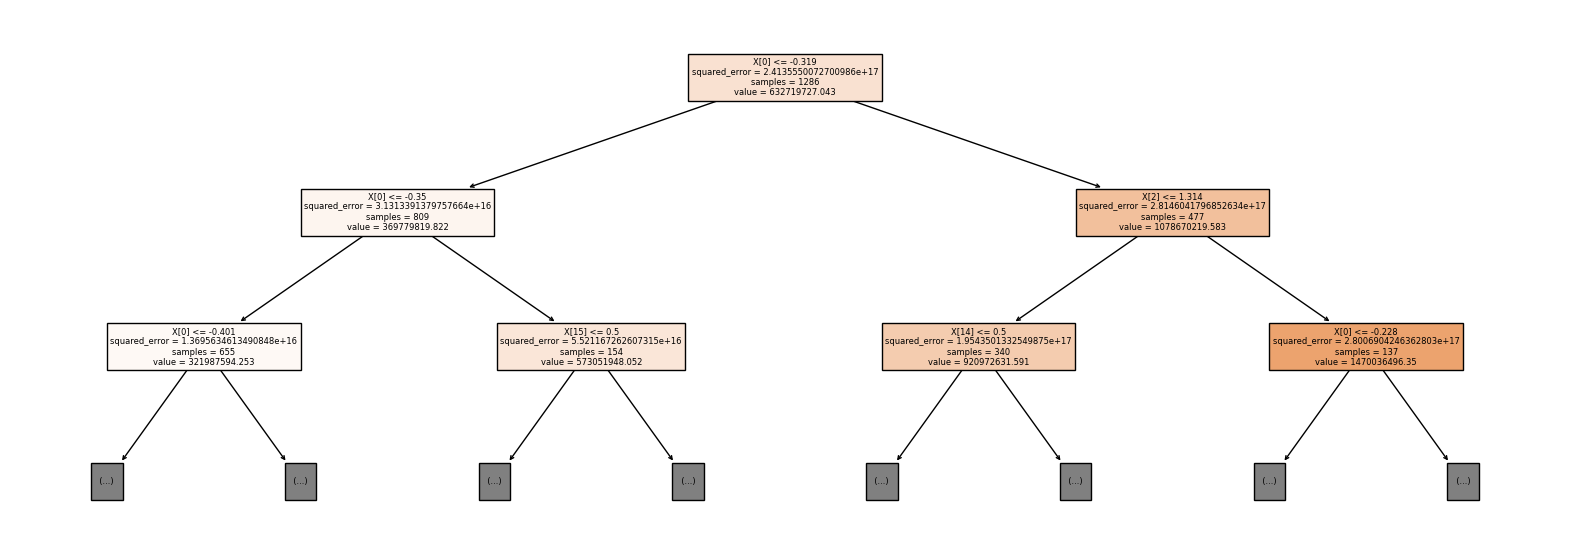

In [27]:
plt.figure(figsize=(20,7))
plot_tree(mdlo_arbol, filled=True,max_depth=2)
plt.show()

In [39]:
y_pred_tree = mdlo_arbol.predict(X_test)

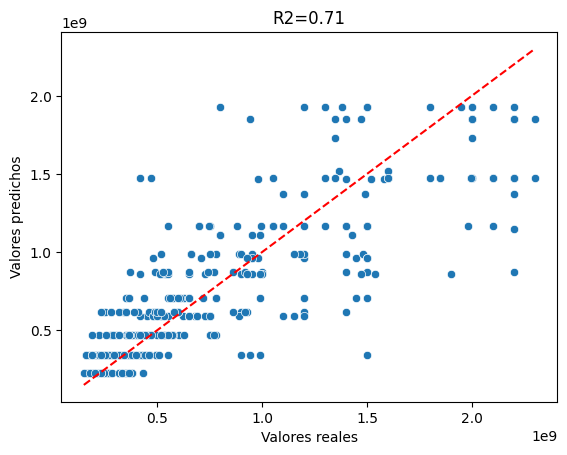

In [42]:
sns.scatterplot(x=y_test, y=y_pred_tree)
sns.lineplot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='r', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title(f'R2={r2_score(y_test, y_pred_tree):.2f}')
plt.show()
plt.show()


Esta grafica muestra los valores reales en el eje x y los valores predichos por el modelo en el eje y. La linea roja punteada representa una prediccion perfecta, es decir, en la que los valores reales y predichos coinciden. Ademas se muestra el coeficiente de determiancion R2 , que indica cuanto varian los valores predichos en funcion de los valores reales

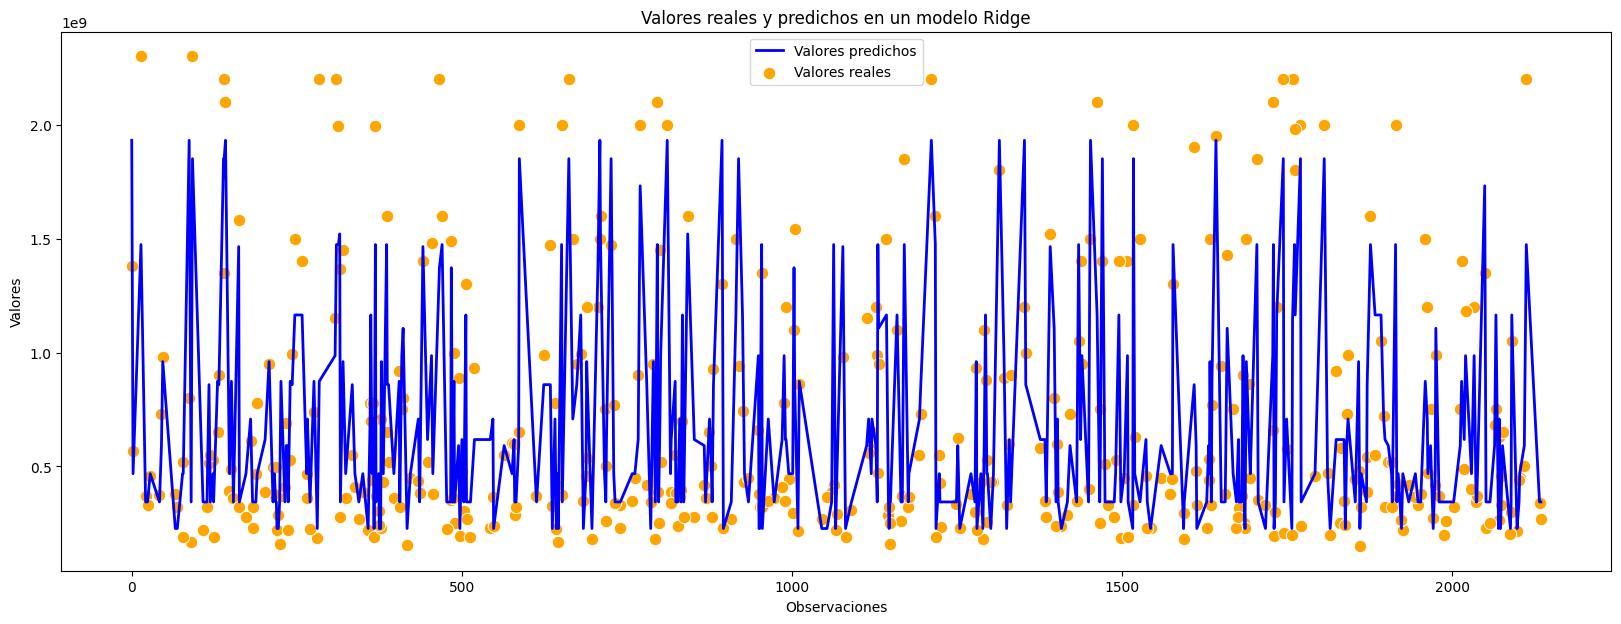

In [50]:
plt.figure(figsize=(20, 7))
df_grafica_test = pd.DataFrame({'Valores reales': y_test, 'Valores predichos': y_pred_tree})
sns.lineplot(x=df_grafica_test.index, y='Valores predichos', data=df_grafica_test, linewidth=2, color='blue')
sns.scatterplot(x=df_grafica_test.index, y='Valores reales', data=df_grafica_test,  s=80, color='orange')
plt.title('Valores reales y predichos en un modelo Ridge')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend(labels=['Valores predichos', 'Valores reales'])

## Conclusion arboles de regresion

Se encontro mediante validacion cruzada que el mejor modelo para un arbol de regresion tiene los siguientes parametros:
* R2: 0.7115
* MSE: 8.389992e+16
* RMSE: 2.896548e+08
* AbsoluteMSE: 1.895405e+08
* Varianza explicada: 0.7119

Se observa una mejoria en los datos de prueba, por lo tanto se puede decir que mediante arboles de regresion el error de generalizacion es mas bajo. Adicionalmente a esto si comparamos este modelo respecto a los de regresion lineal podemos observar una mejoria en las metricas de evaluacion, por lo tanto este modelo por el momento esta teniendo un mejor comportamiento. Si no tenemos en cuenta los demas modelos los resultados de las metricas que arroja no estan mal.